In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from influxdb_client import InfluxDBClient
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import pandas as pd
import joblib
import os

### 데이터 수집

In [45]:
# InfluxDB 접속 정보 불러오기
load_dotenv()

DB_URL=os.getenv('DB_URL')
DB_TOKEN=os.getenv('DB_TOKEN')
DB_ORG=os.getenv('DB_ORG')
DB_BUCKET=os.getenv('DB_BUCKET')

In [46]:
# InfluxDB에서 주어진 측정치에 대한 데이터를 조회하여 DataFrame으로 반환.
def query_influx(measurement, place):
    client = InfluxDBClient(url=DB_URL, token=DB_TOKEN, org=DB_ORG, timeout=30_000)
    query_api = client.query_api()
    
    query = f'''
    import "date"
    import "experimental/query"
    from(bucket: "{DB_BUCKET}")
    |> range(start: date.sub(d: 7d, from: date.truncate(t: now(), unit: 1d)), stop: now())
    |> filter(fn: (r) => r["_measurement"] == "{measurement}")
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> filter(fn: (r) => r.place == "{place}")
    '''
    
    result_df = query_api.query_data_frame(org=DB_ORG, query=query)
    print(f"{place} {measurement} shape: ", result_df.shape)
    
    client.close()
    return result_df

outdoor_temperature_df = query_influx("temperature", "outdoor")
outdoor_humidity_df = query_influx("humidity", "outdoor")
temperature_df = query_influx("temperature", "class_a")
humidity_df = query_influx("humidity", "class_a")
people_count_df = query_influx("total_people_count", "class_a")
magnet_status_df = query_influx("magnet_status", "class_a")


outdoor temperature shape:  (835, 10)
outdoor humidity shape:  (835, 10)
class_a temperature shape:  (28318, 10)
class_a humidity shape:  (28319, 10)
class_a total_people_count shape:  (20398, 10)
class_a magnet_status shape:  (1081, 10)


### 데이터 전처리

In [47]:
# 필요없는 컬럼 삭제 및 한국시간으로 시간대 변환
def clean_and_convert_time(df):
    df = df.drop(columns=['_start', '_stop', 'result', 'table', 'topic', 'device'])
    df['_time'] = pd.to_datetime(df['_time']).dt.tz_convert('Asia/Seoul').dt.tz_localize(None)
    
    return df


temperature_outdoor_df = clean_and_convert_time(outdoor_temperature_df)
humidity_outdoor_df = clean_and_convert_time(outdoor_humidity_df)
temperature_class_a_df = clean_and_convert_time(temperature_df)
humidity_class_a_df = clean_and_convert_time(humidity_df)
people_count_df = clean_and_convert_time(people_count_df)
magnet_status_df = clean_and_convert_time(magnet_status_df)

In [48]:
# resample로 1분단위로 데이터를 합치기 위해 Datetime을 인덱스로 지정
# value에 대해 1분 단위로 평균 or 마지막값 계산. resample을 수행한 후에는 Series 객체가 됨.
def resample_data(df, column, freq, method):
    df = df.set_index('_time')

    if method == 'mean':
        return df[column].resample(freq).mean()
    elif method == 'last':
        return df[column].resample(freq).last()

outdoor_temperature_summary_series = resample_data(temperature_outdoor_df, 'value', 'T', 'mean')
outdoor_humidity_summary_series = resample_data(humidity_outdoor_df, 'value', 'T', 'mean')
temperature_summary_series = resample_data(temperature_class_a_df, 'value', 'T', 'mean')
humidity_summary_series = resample_data(humidity_class_a_df, 'value', 'T', 'mean')
people_count_series = resample_data(people_count_df, 'value', 'T', 'last')
magnet_status_series = resample_data(magnet_status_df, 'value', 'T', 'last')

print(outdoor_temperature_summary_series.head(),'\n', outdoor_humidity_summary_series.head(),'\n', temperature_summary_series.head(),'\n', humidity_summary_series.head(),'\n', people_count_series.head(),'\n',magnet_status_series.head(),'\n')

_time
2024-04-23 17:38:00    18.6
2024-04-23 17:39:00     NaN
2024-04-23 17:40:00     NaN
2024-04-23 17:41:00     NaN
2024-04-23 17:42:00     NaN
Freq: T, Name: value, dtype: float64 
 _time
2024-04-23 17:38:00    53.5
2024-04-23 17:39:00     NaN
2024-04-23 17:40:00     NaN
2024-04-23 17:41:00     NaN
2024-04-23 17:42:00     NaN
Freq: T, Name: value, dtype: float64 
 _time
2024-04-22 09:00:00    23.800
2024-04-22 09:01:00    23.525
2024-04-22 09:02:00    23.800
2024-04-22 09:03:00    23.500
2024-04-22 09:04:00    23.800
Freq: T, Name: value, dtype: float64 
 _time
2024-04-22 09:00:00    48.000000
2024-04-22 09:01:00    49.125000
2024-04-22 09:02:00    48.000000
2024-04-22 09:03:00    49.333333
2024-04-22 09:04:00    48.000000
Freq: T, Name: value, dtype: float64 
 _time
2024-04-22 09:00:00    6.0
2024-04-22 09:01:00    3.0
2024-04-22 09:02:00    6.0
2024-04-22 09:03:00    3.0
2024-04-22 09:04:00    2.0
Freq: T, Name: value, dtype: float64 
 _time
2024-04-22 09:08:00    close
2024-04-22

In [49]:
data_df = pd.DataFrame({
    'outdoor_temperature': outdoor_temperature_summary_series,
    'outdoor_humidity': outdoor_humidity_summary_series,
    'temperature': temperature_summary_series,
    'humidity': humidity_summary_series,
    'people_count': people_count_series,
    'air_conditional': magnet_status_series
})

print(data_df)

                     outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-04-22 09:00:00                  NaN               NaN    23.800000   
2024-04-22 09:01:00                  NaN               NaN    23.525000   
2024-04-22 09:02:00                  NaN               NaN    23.800000   
2024-04-22 09:03:00                  NaN               NaN    23.500000   
2024-04-22 09:04:00                  NaN               NaN    23.800000   
...                                  ...               ...          ...   
2024-04-29 14:13:00                  NaN               NaN    23.433334   
2024-04-29 14:14:00                  NaN               NaN    23.800000   
2024-04-29 14:15:00                  NaN               NaN    23.433334   
2024-04-29 14:16:00                  NaN               NaN    23.850000   
2024-04-29 14:17:00                  NaN               NaN    22.933334   

                      hu

In [50]:
null_values = data_df.isnull().sum()
print('Initial null value:\n', null_values)

# 'air_conditional' 컬럼의 첫 번째 값이 결측치인 경우 'close'로 설정
if pd.isna(data_df['air_conditional'].iloc[0]):
    data_df.at[data_df.index[0], 'air_conditional'] = 'close'

if pd.isna(data_df['outdoor_temperature'].iloc[0]):
    avg_temperature = data_df['outdoor_temperature'].mean()
    data_df.at[data_df.index[0], 'outdoor_temperature'] = avg_temperature

if pd.isna(data_df['outdoor_humidity'].iloc[0]):
    avg_humidity = data_df['outdoor_humidity'].mean()
    data_df.at[data_df.index[0], 'outdoor_humidity'] = avg_humidity

# people_count' 컬럼에서 첫 번째 값이 결측치인 경우, 최근 유효 값으로 채우기
if pd.isna(data_df['people_count'].iloc[0]):
    notnull_peoplecount = data_df[data_df['people_count'].notnull()].iloc[0]['people_count']
    data_df.at[data_df.index[0], 'people_count'] = notnull_peoplecount

# 나머지 결측치 전방 채우기
data_df_filled = data_df.fillna(method='ffill', axis=0)

print('After processing null value: \n', data_df_filled.isnull().sum())
print(data_df_filled.info)

Initial null value:
 outdoor_temperature    9563
outdoor_humidity       9563
temperature               0
humidity                  0
people_count             62
air_conditional        9340
dtype: int64
After processing null value: 
 outdoor_temperature    0
outdoor_humidity       0
temperature            0
humidity               0
people_count           0
air_conditional        0
dtype: int64
<bound method DataFrame.info of                      outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-04-22 09:00:00            19.332575         59.474251    23.800000   
2024-04-22 09:01:00            19.332575         59.474251    23.525000   
2024-04-22 09:02:00            19.332575         59.474251    23.800000   
2024-04-22 09:03:00            19.332575         59.474251    23.500000   
2024-04-22 09:04:00            19.332575         59.474251    23.800000   
...                                  ...       

In [51]:
# 복사본 생성
data_df_filter_by_time = data_df_filled.copy()

- 환경에 따른 에어컨 사용량 분석을 위한 전처리

In [52]:
# 날짜값 제거
data_df_filled_delete_date = data_df_filled
data_df_filled_delete_date.index = data_df_filled_delete_date.index.time
print(data_df_filled_delete_date.head())

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00            19.332575         59.474251       23.800  48.000000   
09:01:00            19.332575         59.474251       23.525  49.125000   
09:02:00            19.332575         59.474251       23.800  48.000000   
09:03:00            19.332575         59.474251       23.500  49.333333   
09:04:00            19.332575         59.474251       23.800  48.000000   

          people_count air_conditional  
09:00:00           6.0           close  
09:01:00           3.0           close  
09:02:00           6.0           close  
09:03:00           3.0           close  
09:04:00           2.0           close  


In [53]:
# 자정으로부터 경과한 분을 계산하기 위한 처리
data_df_filled_delete_date['time'] = data_df_filled_delete_date.index
data_df_filled_delete_date

# 'time' 컬럼의 datetime.time 객체를 분으로 변환하는 함수
def time_to_minutes(t):
    return t.hour * 60 + t.minute

# 'time' 컬럼을 하루 중 분으로 변환
data_df_filled_delete_date['time_in_minutes'] = data_df_filled_delete_date['time'].apply(time_to_minutes)
data_df_filled_delete_date = data_df_filled_delete_date.drop(columns=['time'])

In [54]:
# air_conditional의 값이 close면 0, open이면 1로 변경
data_df_filled_delete_date['air_conditional'] = data_df_filled_delete_date['air_conditional'].map({'close': 0, 'open': 1})
print(data_df_filled_delete_date.head())

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00            19.332575         59.474251       23.800  48.000000   
09:01:00            19.332575         59.474251       23.525  49.125000   
09:02:00            19.332575         59.474251       23.800  48.000000   
09:03:00            19.332575         59.474251       23.500  49.333333   
09:04:00            19.332575         59.474251       23.800  48.000000   

          people_count  air_conditional  time_in_minutes  
09:00:00           6.0                0              540  
09:01:00           3.0                0              541  
09:02:00           6.0                0              542  
09:03:00           3.0                0              543  
09:04:00           2.0                0              544  


In [55]:
# 내외부 온도, 습도, 사람수에 따른 상관계수 계산
correlation_matrix = data_df_filled_delete_date.corr()
print(correlation_matrix)

                     outdoor_temperature  outdoor_humidity  temperature  \
outdoor_temperature             1.000000         -0.623538     0.069070   
outdoor_humidity               -0.623538          1.000000    -0.239968   
temperature                     0.069070         -0.239968     1.000000   
humidity                        0.151953          0.469985    -0.384902   
people_count                    0.023631         -0.087918     0.490935   
air_conditional                 0.312373         -0.163020    -0.259518   
time_in_minutes                 0.432094         -0.311786     0.339111   

                     humidity  people_count  air_conditional  time_in_minutes  
outdoor_temperature  0.151953      0.023631         0.312373         0.432094  
outdoor_humidity     0.469985     -0.087918        -0.163020        -0.311786  
temperature         -0.384902      0.490935        -0.259518         0.339111  
humidity             1.000000     -0.039944         0.268867        -0.055120  

In [56]:
# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = data_df_filled_delete_date.columns
vif_data["VIF"] = [variance_inflation_factor(data_df_filled_delete_date.values, i) for i in range(data_df_filled_delete_date.shape[1])]

print(vif_data)

               feature         VIF
0  outdoor_temperature  319.289498
1     outdoor_humidity  207.182614
2          temperature  338.099256
3             humidity  420.760376
4         people_count    1.885090
5      air_conditional    2.431351
6      time_in_minutes    5.332451


- VIF 값이 10 이상이면 해당 변수가 다른 독립변수들과 높은 상관관계를 가지고 있어 다중공선성이 존재할 가능성이 높다고 판단
- 다중공선성은 주로 회귀분석 모델에서 독립변수 간의 강한 상관관계 때문에 모델의 계수 추정치가 불안정하게 되어 모델 예측에 부정적인 영향을 끼칠 수 있음. 따라서 로지스틱 회귀모델에서는 높은 다중공선성을 가진 컬럼중 일부를 삭제하거나 변형하여 학습하는 것이 좋을 것 같음.

- 시간에 따른 에어컨 사용량 분석을 위한 전처리

In [57]:
# air_conditional의 값이 close면 0, open이면 1로 변경
data_df_filter_by_time['air_conditional'] = data_df_filter_by_time['air_conditional'].map({'close': 0, 'open': 1})

print(data_df_filter_by_time.head())
print(data_df_filter_by_time.info)

                     outdoor_temperature  outdoor_humidity  temperature  \
_time                                                                     
2024-04-22 09:00:00            19.332575         59.474251       23.800   
2024-04-22 09:01:00            19.332575         59.474251       23.525   
2024-04-22 09:02:00            19.332575         59.474251       23.800   
2024-04-22 09:03:00            19.332575         59.474251       23.500   
2024-04-22 09:04:00            19.332575         59.474251       23.800   

                      humidity  people_count  air_conditional  
_time                                                          
2024-04-22 09:00:00  48.000000           6.0                0  
2024-04-22 09:01:00  49.125000           3.0                0  
2024-04-22 09:02:00  48.000000           6.0                0  
2024-04-22 09:03:00  49.333333           3.0                0  
2024-04-22 09:04:00  48.000000           2.0                0  
<bound method DataFrame.in

In [58]:
# 30분 평균 에어컨 온도 사용량
data_df_filter_by_time = data_df_filter_by_time.drop(columns=['outdoor_temperature', 'outdoor_humidity', 'temperature', 'humidity', 'people_count'])
data_df_filter_by_time['air_conditional'].resample('30T').mean()

# 날짜를 제외하고 시간 인덱스에서 시간 부분만 추출
times_only = data_df_filter_by_time['air_conditional'].resample('30T').mean().index.time

# 시간을 DataFrame의 새 인덱스로 설정
resampled_data = data_df_filter_by_time['air_conditional'].resample('30T').mean()
resampled_data.index = times_only

# 시간을 기준으로 그룹화하고 각 그룹의 평균을 계산
grouped_by_time = resampled_data.groupby(resampled_data.index).mean()

print(grouped_by_time.head())

00:00:00    0.247619
00:30:00    0.142857
01:00:00    0.142857
01:30:00    0.142857
02:00:00    0.142857
Name: air_conditional, dtype: float64


### 데이터 시각화

- 환경에 따른 에어컨 사용량 분석

/home/gahyoung/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


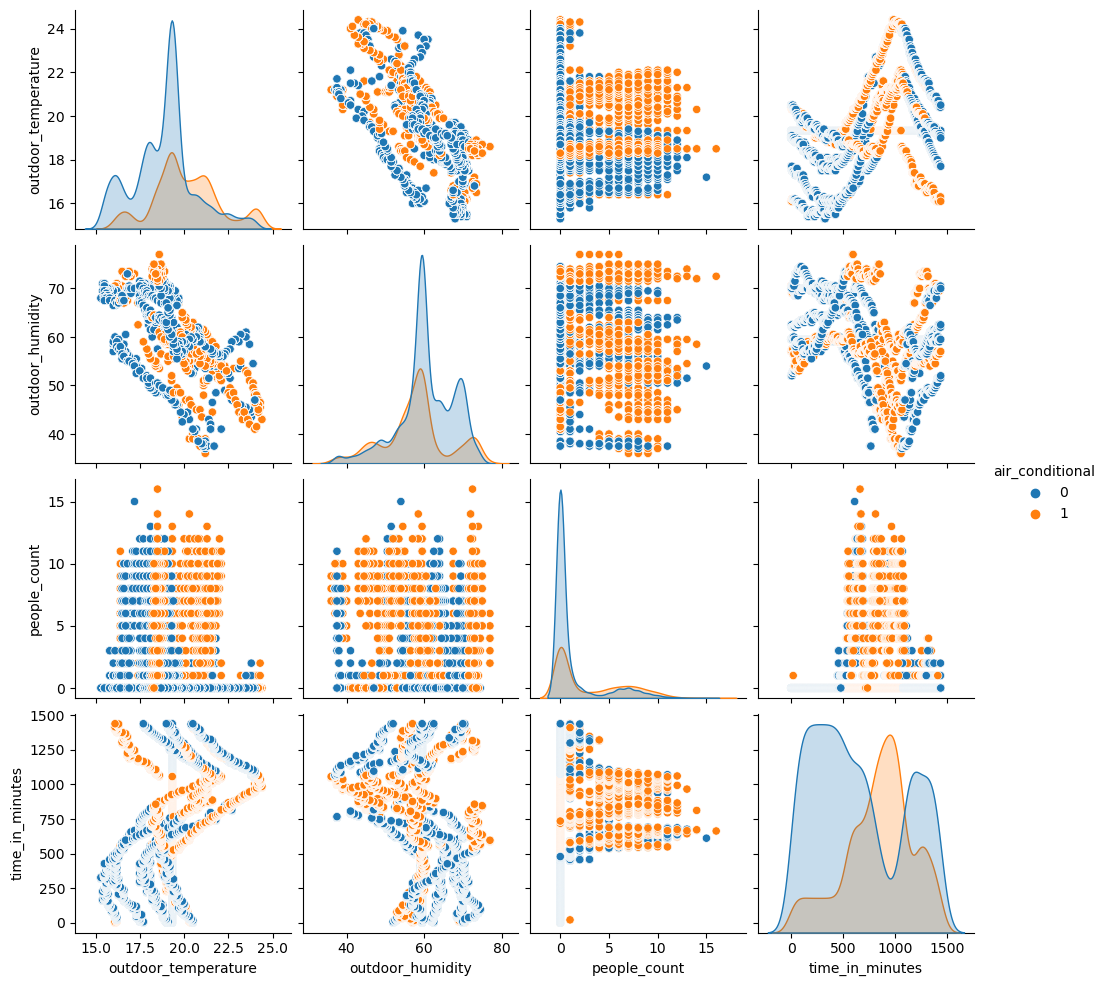

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 그리기
sns.pairplot(data_df_filled_delete_date, hue='air_conditional', vars=['outdoor_temperature', 'outdoor_humidity', 'people_count', 'time_in_minutes'])
plt.show()

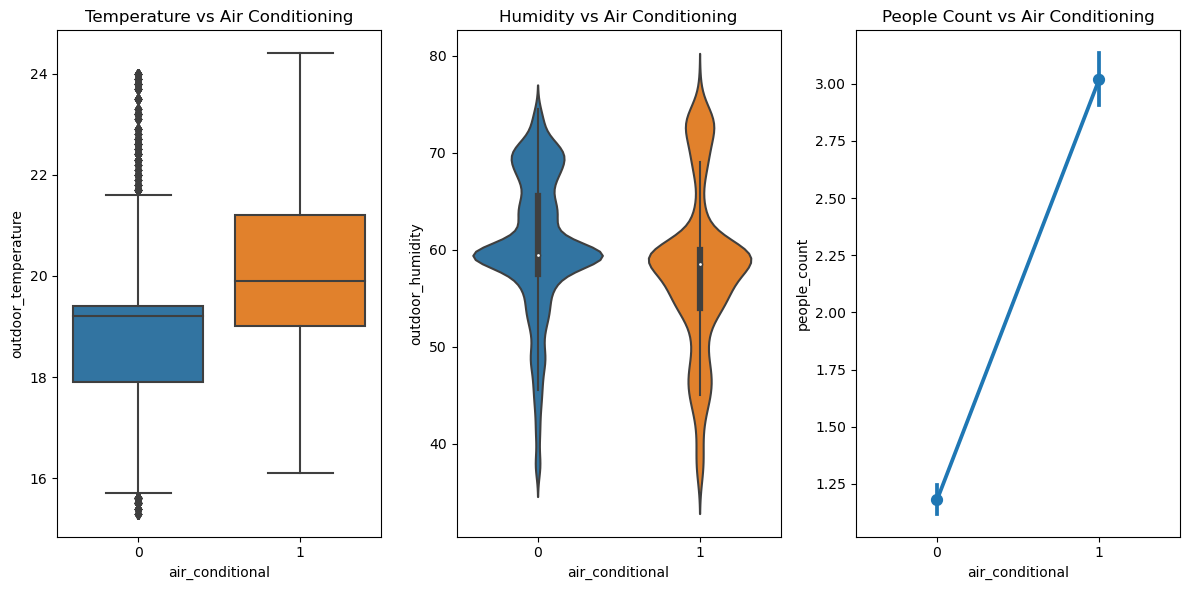

In [60]:
# 데이터 세트 설정
data = data_df_filled_delete_date

# 1. 외부 온도와 에어컨의 상관관계 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x='air_conditional', y='outdoor_temperature', data=data)
plt.title('Temperature vs Air Conditioning')

# 2. 외부 습도와 에어컨의 상관관계 시각화
plt.subplot(1, 3, 2)
sns.violinplot(x='air_conditional', y='outdoor_humidity', data=data)
plt.title('Humidity vs Air Conditioning')

# 3. 재실 인원과 에어컨의 상관관계 시각화
plt.subplot(1, 3, 3)
sns.pointplot(x='air_conditional', y='people_count', data=data)
plt.title('People Count vs Air Conditioning')

plt.tight_layout()
plt.show()


- 시간에 따른 에어컨 사용량 분석

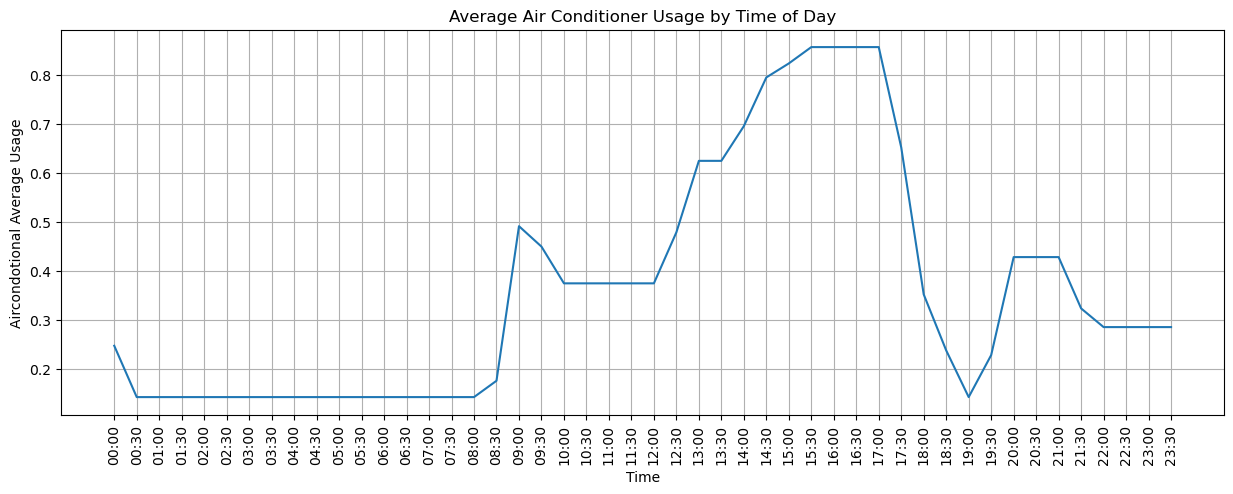

In [61]:
# grouped_by_time 인덱스를 하루 중 분으로 변환
minutes_since_midnight = [t.hour * 60 + t.minute for t in grouped_by_time.index]

# 데이터 시각화
fig, ax = plt.subplots(figsize=(15, 5))

# 선 그래프 그리기
ax.plot(minutes_since_midnight, grouped_by_time.values)

# 제목 및 라벨 설정
ax.set_title('Average Air Conditioner Usage by Time of Day')
ax.set_xlabel('Time')
ax.set_ylabel('Aircondotional Average Usage')

# x축 눈금 라벨 설정
# x축 눈금을 시간:분 형태로 표시
ax.set_xticks(minutes_since_midnight)  # 눈금 설정
ax.set_xticklabels([f'{t.hour:02}:{t.minute:02}' for t in grouped_by_time.index], rotation=90)

# 그리드 추가
ax.grid(True)

# 그래프 보여주기
plt.show()


### 분석 결과
1. 환경에 따른 에어컨 사용량 분석 : outdoor_temperature 또는 outdoor_humidity가 높을때 people_count가 함께 높을수록 에어컨을 키는 빈도가 늘어난다.
2. 시간에 따른 에어컨 사용량 분석 : 학생들이 입실하는 오전 9시, 점심시간이후이 12시부터 에어컨 사용량이 늘어난다. 학원이 마치는 시간인 6시 이후부터는 사용량이 줄어들다가 12시 반 이후가 되면 에어컨이 꺼질 확률이 높다.

### 모델링
1. 데이터 분할

In [62]:
print(data_df_filled_delete_date.head())

          outdoor_temperature  outdoor_humidity  temperature   humidity  \
09:00:00            19.332575         59.474251       23.800  48.000000   
09:01:00            19.332575         59.474251       23.525  49.125000   
09:02:00            19.332575         59.474251       23.800  48.000000   
09:03:00            19.332575         59.474251       23.500  49.333333   
09:04:00            19.332575         59.474251       23.800  48.000000   

          people_count  air_conditional  time_in_minutes  
09:00:00           6.0                0              540  
09:01:00           3.0                0              541  
09:02:00           6.0                0              542  
09:03:00           3.0                0              543  
09:04:00           2.0                0              544  


In [63]:
# 훈련데이터와 테스트 데이터 분리
X = data_df_filled_delete_date[['outdoor_temperature', 'outdoor_humidity', 'people_count', 'time_in_minutes']]
y = data_df_filled_delete_date['air_conditional']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2. 모델 훈련 및 평가

In [64]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 데이터 준비: X는 온도와 습도, y는 에어컨의 ON/OFF 상태
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# 모델 평가
from sklearn.metrics import accuracy_score
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

In [65]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 성능 평가
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

In [66]:
# XG 부스트
import xgboost as xgb

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 학습
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# 예측 및 성능 평가
xgboost_predictions = xgboost_model.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, xgboost_predictions)

In [67]:
print("LogisticRegression Accuracy:", log_reg_accuracy)
print("RandomForest Accuracy:", rf_accuracy)
print("XGBoost Accuracy:", xgboost_accuracy)

LogisticRegression Accuracy: 0.7038461538461539
RandomForest Accuracy: 0.9634615384615385
XGBoost Accuracy: 0.9706730769230769


In [68]:
print(y.value_counts())

0    6606
1    3792
Name: air_conditional, dtype: int64


In [69]:
from sklearn.metrics import classification_report

print(classification_report(y_test, log_reg_predictions))
print(classification_report(y_test, rf_predictions))
print(classification_report(y_test, xgboost_predictions))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1308
           1       0.62      0.51      0.56       772

    accuracy                           0.70      2080
   macro avg       0.68      0.66      0.67      2080
weighted avg       0.70      0.70      0.70      2080

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1308
           1       0.95      0.95      0.95       772

    accuracy                           0.96      2080
   macro avg       0.96      0.96      0.96      2080
weighted avg       0.96      0.96      0.96      2080

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1308
           1       0.95      0.97      0.96       772

    accuracy                           0.97      2080
   macro avg       0.97      0.97      0.97      2080
weighted avg       0.97      0.97      0.97      2080



3. 모델 선택

In [70]:
# 모델 저장 경로와 파일 이름 설정
MODEL_NAME = 'air_conditional_ai_model.joblib'
MODEL_PATH = './' 

# 모델 저장
joblib.dump(rf_model, MODEL_PATH + MODEL_NAME)

['./air_conditional_ai_model.joblib']

- RandomForest Accuracy가 가장 정확도가 높은 분류기.